# Term Paper

### Part 1

In [7]:
import pandas as pd
import glob as glob

In [8]:
#Defining a function to compute and print dataset statistics
def compute_statistics():
    num_individuals = sce_df["userid"].nunique() # Number of Unique userids (individuals)
    num_observations = len(sce_df)               # Total number of observations
    num_waves = sce_df["wid"].nunique()          # Number of Unique survey waves
    first_date = sce_df["date"].min()            # Earliest survey date
    last_date = sce_df["date"].max() # Latest survey date

    # Output the statistics
    print(f"Unique individuals: {num_individuals}") 
    print(f"Total observations: {num_observations}")
    print(f"Unique survey waves: {num_waves}")
    print(f"Date range: {first_date.date()} to {last_date.date()}")

In [9]:
files=glob.glob(f'data/SCE-*-20*.csv')

df_list=[]

waves_number=0

#Loop to read in and append files
for file in files:
    df=pd.read_csv(file,sep=";",parse_dates=['date'])
    df_list.append(df)


sce_df=pd.concat(df_list,ignore_index=True)

compute_statistics()

Unique individuals: 23369
Total observations: 176101
Unique survey waves: 139
Date range: 2013-06-01 to 2024-12-31


### Part 2

In [10]:
# Forward-fill numeracy variables for each individual
numeracy_cols = [
    'num_lit_q1_correct', 'num_lit_q2_correct', 'num_lit_q3_correct',
    'num_lit_q5_correct', 'num_lit_q6_correct', 'num_lit_q8_correct', 'num_lit_q9_correct'
]

# Replace blank strings with NaN (if your CSV uses empty fields)
sce_df[numeracy_cols] = sce_df[numeracy_cols].replace("", pd.NA)


# Group by userid, then forward-fill within each person
sce_df[numeracy_cols] = sce_df.groupby('userid')[numeracy_cols].ffill()

# Drop all rows that still have NaN
numeracy_cols.extend(['female','educ','age','inflation','house_price_change','prob_stocks_up'])
sce_df.dropna(subset=numeracy_cols,inplace=True)

#Eliminate 0.1th percentile and 99.9th percentile of answers
numeracy_cols = [
    'num_lit_q1_correct', 'num_lit_q2_correct', 'num_lit_q3_correct',
    'num_lit_q5_correct', 'num_lit_q6_correct', 'num_lit_q8_correct', 'num_lit_q9_correct'
]
lower_bounds=sce_df[numeracy_cols].quantile(0.001)
upper_bounds=sce_df[numeracy_cols].quantile(0.999)
for col in numeracy_cols:
    sce_df=sce_df[(sce_df[col]>=lower_bounds[col]) & (sce_df[col]<=upper_bounds[col])]

#Creating a column to determine whether the individual has a bachelor's degree or higher
sce_df['college']=(sce_df['educ']>3).astype(int)

#Compute the total number of correct numeracy responces
sce_df['numeracy_score']=sce_df[numeracy_cols].sum(axis=1)

#Compute the average numeracy score
percentage=sce_df['numeracy_score'].value_counts(normalize=True)*100
percentage.sort_index(inplace=True)
print(f"Numeracy Score Distribution (%): {percentage}")

#Creating a column to determine if the individual has a higher numeracy score than the median
median_score = sce_df['numeracy_score'].median()
sce_df['num_lit_high'] = (sce_df['numeracy_score'] > median_score).astype(int)

#Calling the function to compute and print updated dataset statistics
compute_statistics()

Numeracy Score Distribution (%): numeracy_score
0.0     0.134165
1.0     0.632491
2.0     1.990749
3.0     5.420255
4.0     9.443919
5.0    16.483095
6.0    27.529325
7.0    38.366001
Name: proportion, dtype: float64
Unique individuals: 17700
Total observations: 78262
Unique survey waves: 117
Date range: 2015-04-02 to 2024-12-31


### Part 4

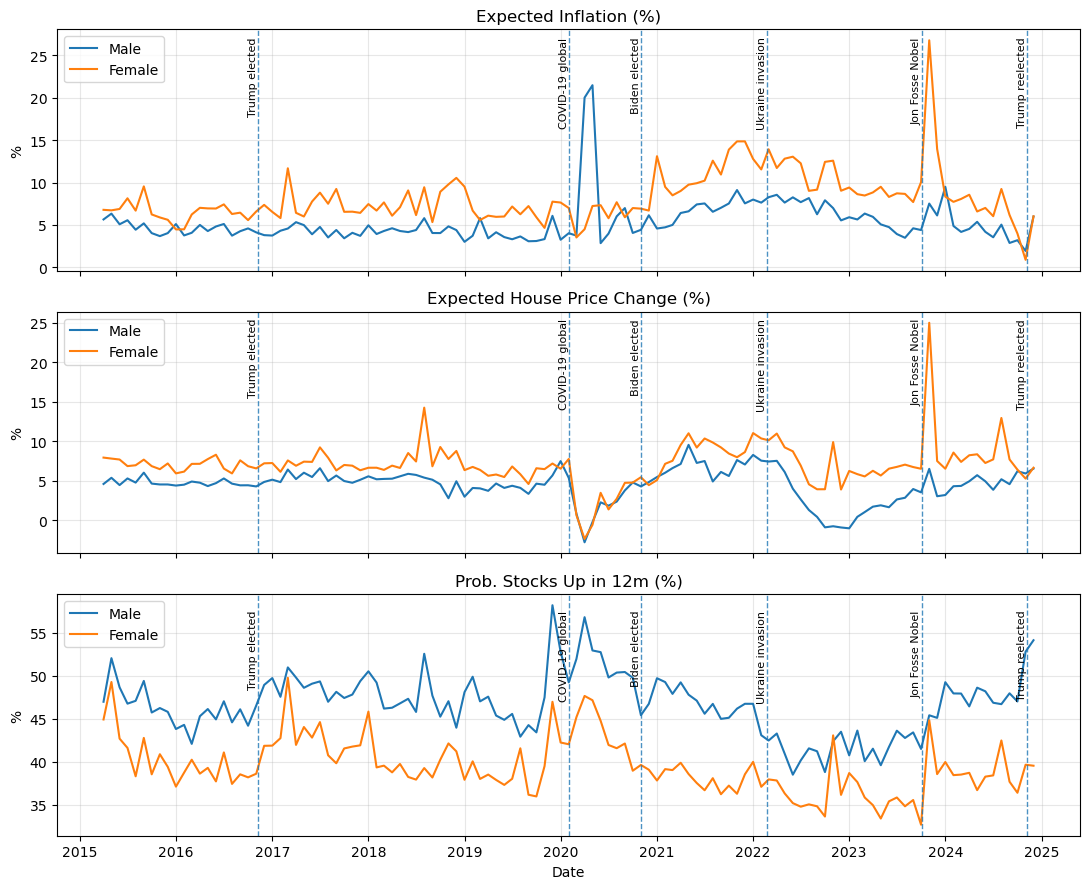

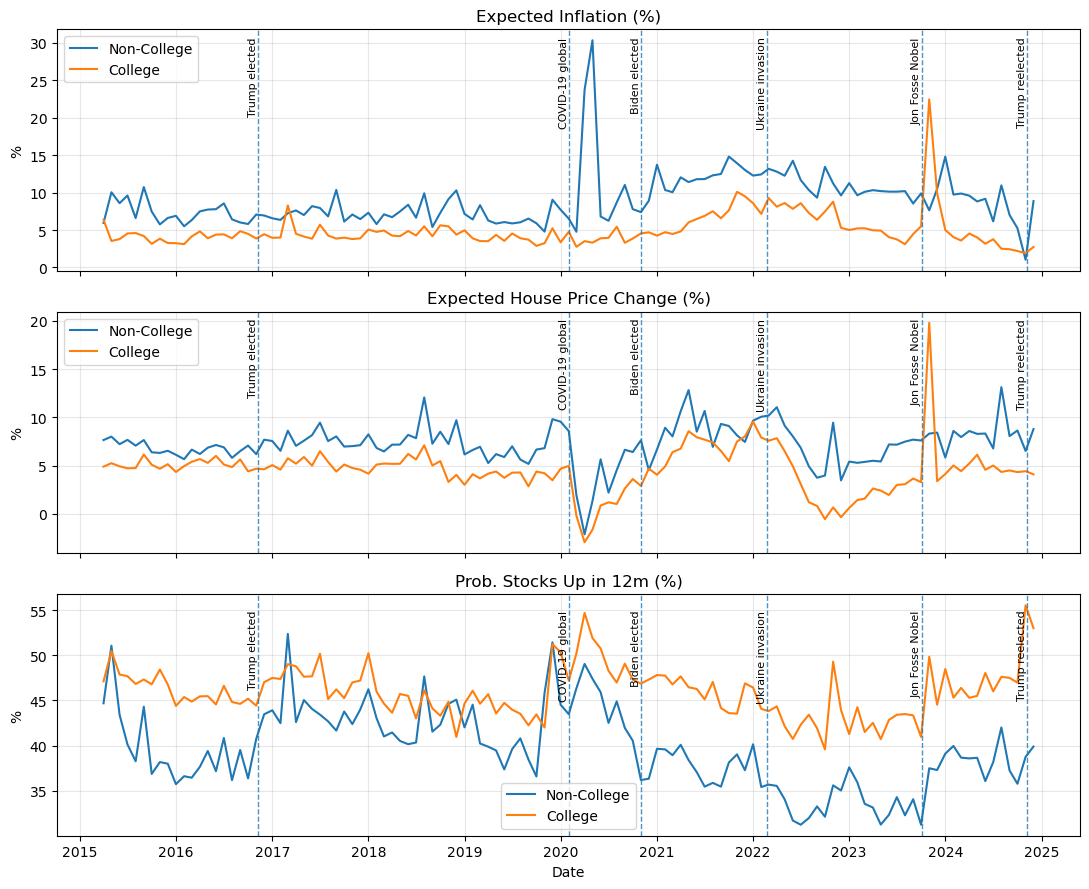

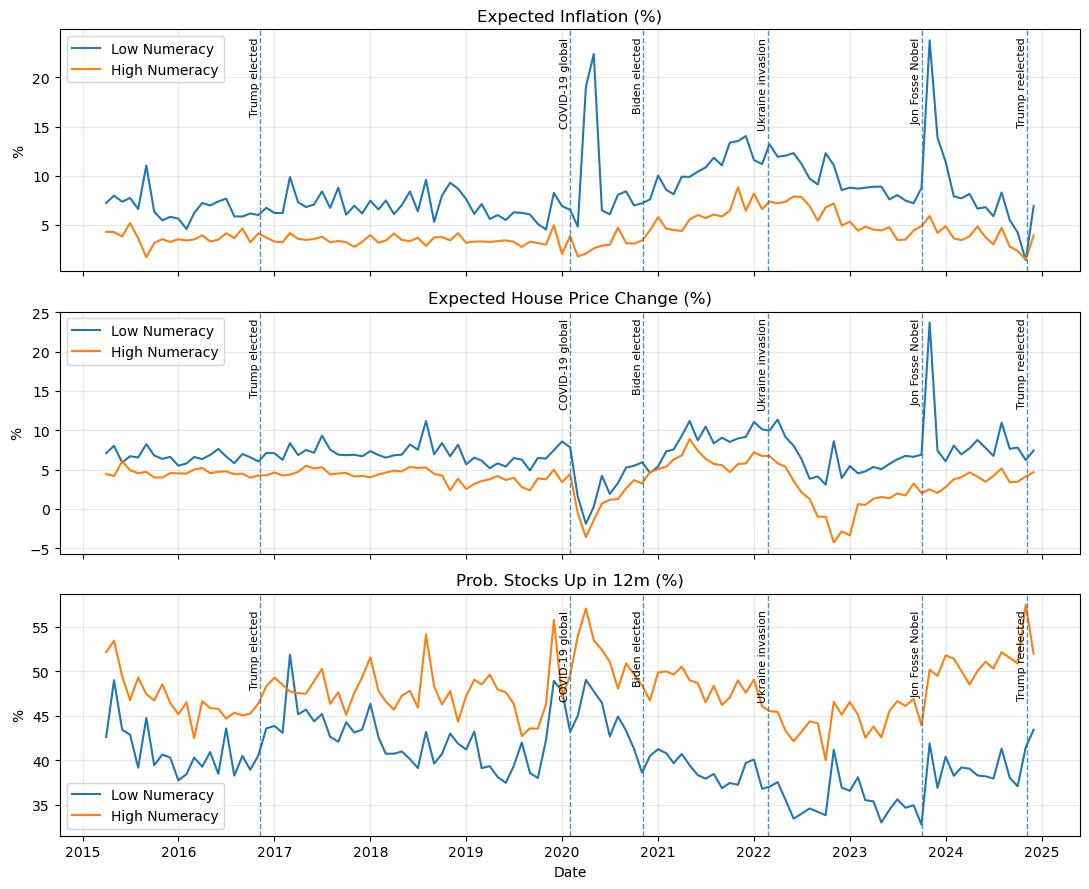

In [11]:
import matplotlib.pyplot as plt

# Function to ensure "date" column is datetime


#def _ensure_date_column(df: pd.DataFrame) -> pd.DataFrame:
 #   df2 = df.copy()
 #   if 'date' not in df2.columns:
  #      if df2.index.name == 'date':
 #           df2['date'] = df2.index
  #      else:
   #         raise KeyError("No 'date' column and index is not named 'date'.")
    #    if df2.index.name == 'date':
     #       df2['date'] = df2.index
      #  else:
       #     raise KeyError("No 'date' column and index is not named 'date'.")
   # df2['date'] = pd.to_datetime(df2['date'], errors='coerce')
    #return df2

# Function to compute monthly averages for specified group variable

def monthly_group_avg(df: pd.DataFrame, group_var: str) -> pd.DataFrame:
    df2 = _ensure_date_column(df)
    exp_cols = ['inflation', 'house_price_change', 'prob_stocks_up']
    return (
        df2.groupby([group_var, pd.Grouper(key='date', freq='MS')])[exp_cols]
           .mean()
           .reset_index()
           .sort_values(['date', group_var])
    )

# Function to plot expectation dynamics

def plot_expectation_dynamics(df_monthly: pd.DataFrame, group_var: str, labels: dict):
    fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)
    vars_  = ['inflation', 'house_price_change', 'prob_stocks_up']
    titles = ['Expected Inflation (%)',
              'Expected House Price Change (%)',
              'Prob. Stocks Up in 12m (%)']
# Loop over variables and plot
    for i, var in enumerate(vars_):
        ax = axes[i]
        for val, lab in labels.items():
            sub = df_monthly[df_monthly[group_var] == val]
            ax.plot(sub['date'], sub[var], label=lab)
        ax.set_title(titles[i]); ax.set_ylabel('%'); ax.grid(True, alpha=0.3); ax.legend()
# Annotate significant events
    events = [
        ('2016-11-08', 'Trump elected'),
        ('2020-02-01', 'COVID-19 global'),
        ('2020-11-03', 'Biden elected'),
        ('2022-02-24', 'Ukraine invasion'),
        ('2023-10-03', 'Jon Fosse Nobel'),
        ('2024-11-05', 'Trump reelected'),
    ]
    # Add vertical lines and labels for events
    for d, lab in events:
        x = pd.to_datetime(d)
        for ax in axes:
            ax.axvline(x, linestyle='--', linewidth=1, alpha=0.8)
            ymax = ax.get_ylim()[1]
            ax.text(x, ymax*0.97, lab, rotation=90, va='top', ha='right', fontsize=8)
# Label x-axis on the bottom plot
    axes[-1].set_xlabel('Date')
    fig.tight_layout()
    plt.show()

# Generate and plot monthly averages
monthly_gender  = monthly_group_avg(sce_df, 'female')
plot_expectation_dynamics(monthly_gender, 'female', {0: 'Male', 1: 'Female'})

monthly_college = monthly_group_avg(sce_df, 'college')
plot_expectation_dynamics(monthly_college, 'college', {0: 'Non-College', 1: 'College'})

monthly_numlit  = monthly_group_avg(sce_df, 'num_lit_high')
plot_expectation_dynamics(monthly_numlit, 'num_lit_high', {0: 'Low Numeracy', 1: 'High Numeracy'})

# --> have a look through this code to make sure understandable and well commented. 